# VU Econometics and Data Science: Case Study
```
Author(s): Jacco Broere
```


### Setup
- Setup config.ini file
- Install necessary packages
- Download and unpack data



In [2]:
# import utility modules
import pandas as pd
import numpy as np
import configparser
import os

# import sweetviz

import matplotlib.pyplot as plt

# import optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# helper functions
from helpers.helper_functions import transform_data, add_actuals
from helpers.helper_classes import AddFeatureNames

# sklearn
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# LightGBM
from lightgbm import LGBMClassifier

from joblib import dump, load


# feature_engine
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures

c:\Users\caspa\Desktop\VU_git\vu-case-study-eds\.venv\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

os.chdir(config['PATH']['ROOT_DIR'])

In [4]:
# Read data
raw_train = pd.read_csv(config['PATH']['RAW_TRAIN_DATA'])
raw_test = pd.read_csv(config['PATH']['RAW_TEST_DATA'])
actuals = pd.read_csv(config['PATH']['ACTUALS'])

# Read parameters
SEED = config.getint('PARAMS', 'SEED')
N_COMPONENTS = config.getint('PARAMS', 'N_COMPONENTS')

### Data exploration

In [5]:
# Check total missing values
print(f"Missing values in training set: {raw_train.isna().sum().sum()}")
print(f"Missing values in test set: {raw_test.isna().sum().sum()}")
print(f"Missing values in actuals: {actuals.isna().sum().sum()}")

Missing values in training set: 0
Missing values in test set: 0
Missing values in actuals: 0


### Setup preprocessing, PCA, and SparsePCA

In [6]:
def get_pca_pipe(n_comps = N_COMPONENTS):
    return Pipeline([    
    # Step 1:
        # Apply PCA
        ('pca', PCA(n_components=n_comps, random_state=SEED)),
    # Step 2:
        # Add feature names
        ('add_features_names', AddFeatureNames(prefix="cmpnt_"))
    ])

def get_spca_pipeline(n_comps = N_COMPONENTS):
    return Pipeline([
        # Step 1:
            # Apply SPCA
            ('spca', SparsePCA(n_components=n_comps, random_state=SEED, alpha=1, max_iter=400, n_jobs = -1)),
        # Step 2:
            # Add feature names
            ('add_features_names', AddFeatureNames(prefix="cmpnt_"))
    ])

preprocessing_pipe = Pipeline([
    # Step 0:
        # Drop constant and duplicate features
        ('drop_features', DropFeatures(features_to_drop=["cancer"])),
        ('drop_constant', DropConstantFeatures(tol=0.98)),

    # Step 1:
        # Apply scaling to data as it is a requirement for the variance maximization procedure of PCA
        ('scaler', StandardScaler()),
])

In [23]:
# Transform data to accesible format and add actuals
train = transform_data(raw_train)
train = add_actuals(train, actuals)
test = transform_data(raw_test)
test = add_actuals(test, actuals)

# Data with 80/20 split
full_df = pd.concat([train, test])
train80, test20 = train_test_split(full_df, test_size=0.2, random_state=SEED)

# Get target for 80/20 split
X_train, X_test = preprocessing_pipe.fit_transform(train80), preprocessing_pipe.transform(test20)
y_train, y_test = train80['cancer'], test20['cancer']

In [24]:
## Fit and save SPCA pipelines
# Normal data, spca, 30 features
# spca_pipe_30.fit(train)
# spca_filename_30 = config['LOGGING']['PIPE_DIR'] + 'spca_pipe_' + str(N_COMPONENTS) +  'comp.lib'
# dump(spca_pipe30, spca_filename)
# spca_pipe_30 = load(spca_filename_30)

# spca_pipe_50 = get_spca_pipeline(n_comps = 50)
# spca_pipe_50.fit(X_train)
spca_filename = config['LOGGING']['PIPE_DIR'] + 'spca_pipe_8020_' + str(50) +  'comp.lib'
spca_pipe_50 = load(spca_filename)

## Load SPCA pipeline from save
spca_pipe = spca_pipe_50
X_train_spca = spca_pipe.transform(X_train)
X_test_spca = spca_pipe.transform(X_test)

## Fit PCA pipeline
pca_pipe = get_pca_pipe(n_comps = 50)
pca_pipe.fit(X_train)

X_train_pca = pca_pipe.transform(X_train)
X_test_pca = pca_pipe.transform(X_test)

### Model fitting
#### Implemented models
- Logistic regression
- LightGBM (Gradient Tree Boosting)
- SVC (Support Vector Classifier)
- KNN (K Nearest Neighbours Classifier)

In [25]:
pipelines = {}

#### Logistic Regression

In [26]:
def construct_lr_pipe():
        return Pipeline([
                # Apply logistic regression
                ('logistic_regression', LogisticRegression(random_state=SEED))
        ])

In [27]:
# Fit and score PCA with Logistic Regression
lr_pca = construct_lr_pipe()
lr_pca.fit(X_train_pca, y_train)
print(f"{'Score with Logistic Regression and PCA:':<50} {lr_pca.score(X_test_pca, y_test)}")

# Fit and score SPCA with Logistic Regression
lr_spca = construct_lr_pipe()
lr_spca.fit(X_train_spca, y_train)
print(f"{'Score with Logistic Regression and SPCA:':<50} {lr_spca.score(X_test_spca, y_test)}")

pipelines["lr"] = {"spca":lr_spca, "pca":lr_pca}

Score with Logistic Regression and PCA:            1.0
Score with Logistic Regression and SPCA:           1.0


### LightGBM (Gradient Tree Boosting)

In [28]:
def construct_lgbm_pipe():
    return Pipeline([
        # Step 4:
            # Apply LGBM
            ('lgbm_classifier', LGBMClassifier(random_state=SEED))
    ])

In [29]:
# Fit and score PCA with Logistic Regression
lgbm_pca = construct_lgbm_pipe()
lgbm_pca.fit(X_train_pca, y_train)
print(f"{'Score with LGBM and PCA:':<50} {lgbm_pca.score(X_test_pca, y_test)}")

# Fit and score SPCA with Logistic Regression
lgbm_spca = construct_lgbm_pipe()
lgbm_spca.fit(X_train_spca, y_train)
print(f"{'Score with LGBM and SPCA:':<50} {lgbm_spca.score(X_test_spca, y_test)}")

pipelines["lgbm"] = {'spca':lgbm_spca, 'pca':lgbm_pca}

Score with LGBM and PCA:                           0.8666666666666667
Score with LGBM and SPCA:                          0.8


#### LightGBM tuning with optuna

In [30]:
def objective(trial):
    boost_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart"])
    dataset = trial.suggest_categorical("data", ["spca", "pca"])
    if dataset == 'spca':
        data_cur = X_train_spca
    else:
        data_cur = X_train_pca

    n_leaves = trial.suggest_int('num_leaves', 3, 40)
    n_est = trial.suggest_int('n_estimators', 30, 400)
    max_d = trial.suggest_int('max_depth', 2, 50)

    clf = LGBMClassifier(random_state=SEED,
                        boosting_type = boost_type, 
                        num_leaves = n_leaves,
                        n_estimators = n_est,
                        max_depth = max_d)

    score = cross_val_score(clf, data_cur, y_train, n_jobs = -1, cv = 3)
    f1 = score.mean()
    return f1

In [31]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
print(study.best_trial)

FrozenTrial(number=0, values=[0.631578947368421], datetime_start=datetime.datetime(2023, 1, 21, 18, 2, 48, 308154), datetime_complete=datetime.datetime(2023, 1, 21, 18, 2, 48, 327174), params={'boosting_type': 'gbdt', 'data': 'pca', 'num_leaves': 22, 'n_estimators': 245, 'max_depth': 41}, distributions={'boosting_type': CategoricalDistribution(choices=('gbdt', 'dart')), 'data': CategoricalDistribution(choices=('spca', 'pca')), 'num_leaves': IntUniformDistribution(high=40, low=3, step=1), 'n_estimators': IntUniformDistribution(high=400, low=30, step=1), 'max_depth': IntUniformDistribution(high=50, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


No difference between the trials, might be due to a very small training set (score is calculated using cross validation). TODO: change train/test to 80/20 split.

### Support Vector Classifier


In [32]:
def construct_svc_pipe():
    return Pipeline([
        # Step 4:
            # Apply LGBM
            ('SVC', SVC(random_state=SEED))
    ])


In [33]:
svc_pca = construct_svc_pipe()
svc_pca.fit(X_train_pca, y_train)
print(f"SVC PCA score: {svc_pca.score(X_test_pca, y_test)}")

svc_spca = construct_svc_pipe()
svc_spca.fit(X_train_spca, y_train)
print(f"SVC SPCA score: {svc_spca.score(X_test_spca, y_test)}")

SVC PCA score: 0.9333333333333333
SVC SPCA score: 1.0


### KNeighbours Classifier

In [34]:
def construct_knn_pipe():
    return Pipeline([
        # Step 4:
            # Apply LGBM
            ('KNN', KNeighborsClassifier())
    ])


In [35]:
knn_pca = construct_knn_pipe()
knn_pca.fit(X_train_pca, y_train)
print(f"KNN PCA score: {knn_pca.score(X_test_pca, y_test)}")

knn_spca = construct_knn_pipe()
knn_spca.fit(X_train_spca, y_train)
print(f"KNN SPCA score: {knn_spca.score(X_test_spca, y_test)}")

KNN PCA score: 0.8666666666666667
KNN SPCA score: 0.8666666666666667


### Evaluation
bit rough around the edges still.

In [36]:
def classification_report_extensive(classifier, X_test, y_true):
    y_pred = classifier.predict(X_test)
    print(classification_report(y_true, y_pred))
    print(f"ROC_AUC score: {roc_auc_score(y_true, classifier.predict_proba(X_test)[:, 1])}")
    conf_mat = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot()

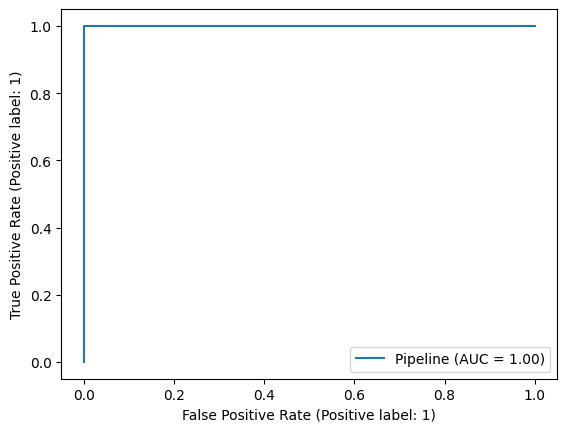

In [37]:
RocCurveDisplay.from_estimator(lr_spca, X_test_spca, y_test)

In [38]:
data = {}
data['leukemia'] = {'none':{'X_train': X_train,'y_train': y_train, 'X_test': X_test, 'y_test': y_test},
                    'pca ': {'X_train': X_train_pca,'y_train': y_train, 'X_test': X_test_pca, 'y_test': y_test},
                    'spca': {'X_train': X_train_spca,'y_train': y_train, 'X_test': X_test_spca, 'y_test': y_test}}
clf_dict = {'lr': LogisticRegression(random_state=SEED),
            'lgbm': LGBMClassifier(random_state=SEED),
            'svc': SVC(random_state=SEED),
            'knn':KNeighborsClassifier()}

for data_name, data_dict in data.items():
    print(f"Dataset: {data_name}")
    print('-'*80)
    for transform_name, data_cur in data_dict.items():
        print()
        print(f"Transform: {transform_name}")
        print('-' * 40)
        for clf_name, clf in clf_dict.items():
            # print(f"Classifier: {clf_name}")
            clf.fit(data_cur['X_train'], data_cur["y_train"])
            y_pred = clf.predict(data_cur['X_test'])
            f1 = f1_score(data_cur['y_test'], y_pred)
            print(f"{clf_name}:\naccuracy: {clf.score(data_cur['X_test'], data_cur['y_test'])}\nf1-score: {f1}")
            # print(f"f1-score: {clf.score(data_cur['X_test'], data_cur['y_test'], scoring = 'f1_score')}")
            # print(f"accuracy: {clf.score(data_cur['X_test'], data_cur['y_test'], scoring = 'roc_auc')}")


Dataset: leukemia
--------------------------------------------------------------------------------

Transform: none
----------------------------------------
lr:
accuracy: 1.0
f1-score: 1.0
lgbm:
accuracy: 1.0
f1-score: 1.0
svc:
accuracy: 0.8666666666666667
f1-score: 0.9166666666666666
knn:
accuracy: 0.8666666666666667
f1-score: 0.9166666666666666

Transform: pca 
----------------------------------------
lr:
accuracy: 1.0
f1-score: 1.0
lgbm:
accuracy: 0.8666666666666667
f1-score: 0.9166666666666666
svc:
accuracy: 0.9333333333333333
f1-score: 0.9565217391304348
knn:
accuracy: 0.8666666666666667
f1-score: 0.9166666666666666

Transform: spca
----------------------------------------
lr:
accuracy: 1.0
f1-score: 1.0
lgbm:
accuracy: 0.8
f1-score: 0.8695652173913043
svc:
accuracy: 1.0
f1-score: 1.0
knn:
accuracy: 0.8666666666666667
f1-score: 0.9166666666666666
